In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [21]:
datafile_path = 'ambient_temperature_system_failure.csv'
raw_dt = pd.read_csv(datafile_path)
data = raw_dt.copy()

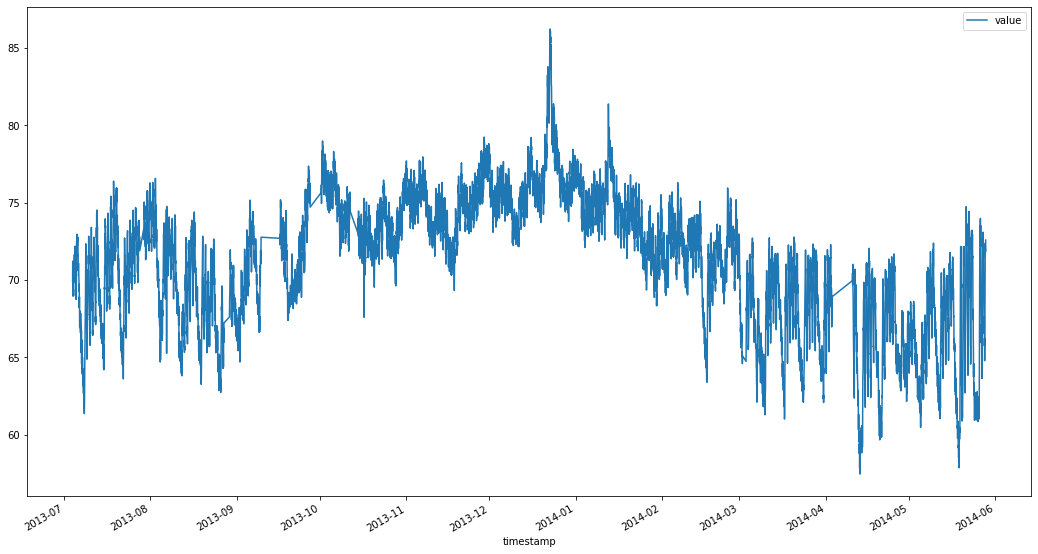

In [25]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(18, 10))

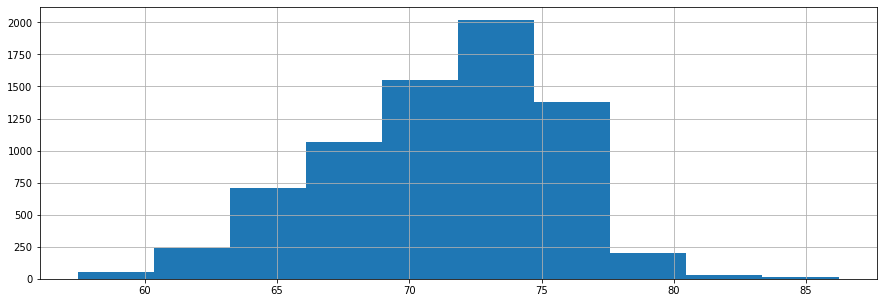

In [27]:
#histogram
data['value'].hist(figsize=(15,5))

In [23]:
data.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [150]:
def season(month):
    spring = (3, 4, 5)
    summer = (6, 7, 8)
    fall = (9, 10, 11)

    if month in spring:
        return 2 
    elif month in summer:
        return 3 
    elif month in fall:
        return 4 
    else:
        return 1 
    
data['hour'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['is_weekend'] = 0
data.loc[data['day_of_week'] == 5, 'is_weekend'] = 1
data.loc[data['day_of_week'] == 6, 'is_weekend'] = 1
data['daylight'] = data['timestamp'].dt.strftime("%p")
data['month'] = data['timestamp'].dt.month
data['season'] = data['timestamp'].dt.month.map(season)
data['year'] = data['timestamp'].dt.year
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)



In [141]:
data

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,year,t,season
0,2013-07-04 00:00:00,69.880835,0.0,3,0,AM,7,2013,13728960,3
1,2013-07-04 01:00:00,71.220227,1.0,3,0,AM,7,2013,13728996,3
2,2013-07-04 02:00:00,70.877805,2.0,3,0,AM,7,2013,13729032,3
3,2013-07-04 03:00:00,68.959400,3.0,3,0,AM,7,2013,13729068,3
4,2013-07-04 04:00:00,69.283551,4.0,3,0,AM,7,2013,13729104,3
...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11.0,2,0,AM,5,2014,14012748,2
7263,2014-05-28 12:00:00,72.172956,12.0,2,0,PM,5,2014,14012784,2
7264,2014-05-28 13:00:00,72.046565,13.0,2,0,PM,5,2014,14012820,2
7265,2014-05-28 14:00:00,71.825226,14.0,2,0,PM,5,2014,14012856,2


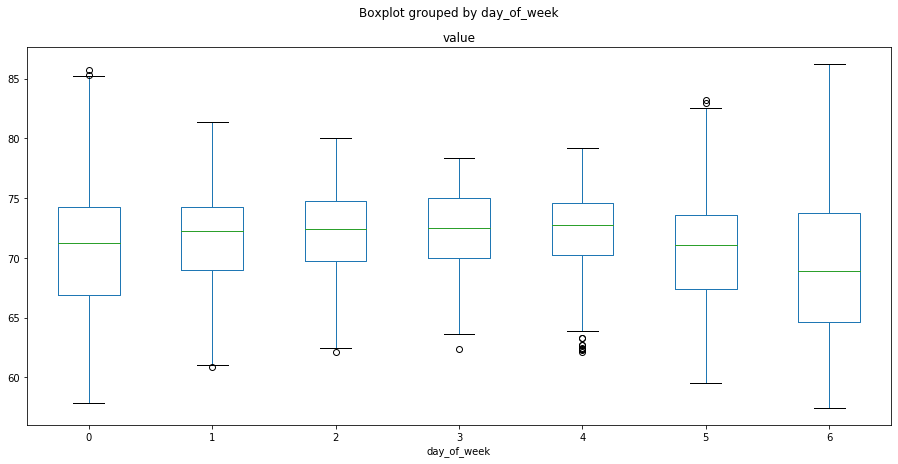

In [37]:
data.boxplot(by='day_of_week', column=['value'], grid=False, figsize=(15,7))

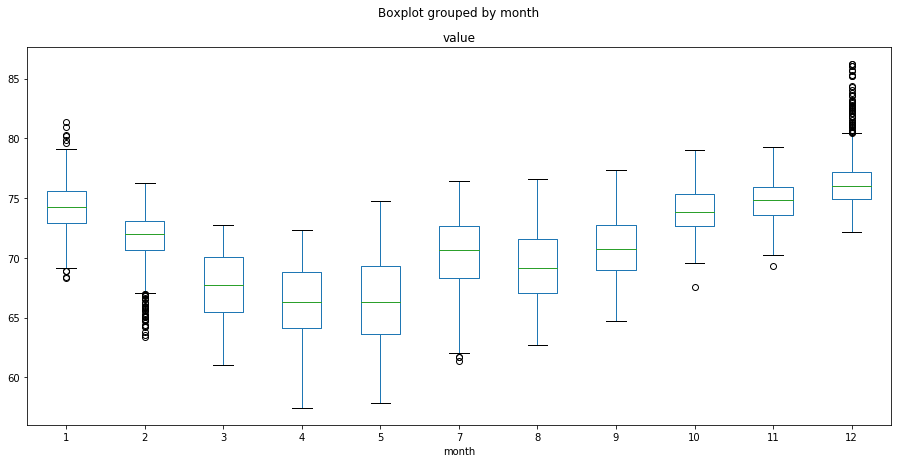

In [38]:
data.boxplot(by='month', column=['value'], grid=False, figsize=(15,7))

<BarContainer object of 11 artists>

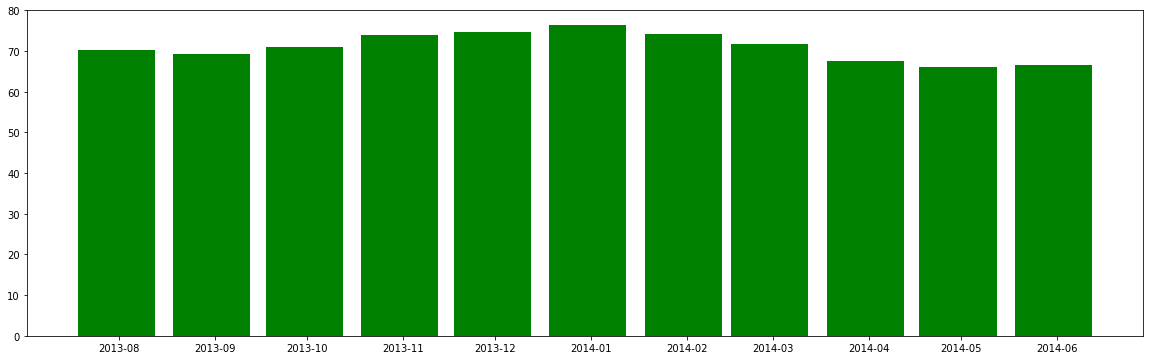

In [114]:
import matplotlib.dates as mdates
bar_d = pd.DataFrame(data=list(data['value']), index=list(data['timestamp']), columns=['value'])
df_month = bar_d.resample("M").mean()
#print(df_month)

fig, ax = plt.subplots(figsize=(20, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.bar(df_month.index, df_month.loc[:, "value"], width=25, align='center', color='g')

In [10]:
from sklearn.model_selection import train_test_split

tr_data, tst_data = train_test_split(data)
tr_data
tst_data

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,year,t
3458,2013-12-11 21:00:00,75.143565,21.0,2,0,PM,12,2013,13867956
5026,2014-02-15 05:00:00,72.020378,5.0,5,1,AM,2,2014,13924404
3552,2013-12-15 19:00:00,77.713470,19.0,6,1,PM,12,2013,13871340
2387,2013-10-28 06:00:00,71.338296,6.0,0,0,AM,10,2013,13829400
1715,2013-09-23 09:00:00,70.514997,9.0,0,0,AM,9,2013,13799268
...,...,...,...,...,...,...,...,...,...
4557,2014-01-26 16:00:00,70.299235,16.0,6,1,PM,1,2014,13907520
4220,2014-01-12 15:00:00,75.717496,15.0,6,1,PM,1,2014,13895388
2029,2013-10-10 10:00:00,72.755208,10.0,3,0,AM,10,2013,13813992
6852,2014-05-11 09:00:00,63.645231,9.0,6,1,AM,5,2014,13997988


In [12]:
#Missing Values

print('Number of missings by feature:\n',data.isnull().sum())

Number of missins by feature:
 timestamp      0
value          0
hour           0
day_of_week    0
is_weekend     0
daylight       0
month          0
year           0
t              0
dtype: int64


In [13]:
#Incorrect Values
from numpy import nan
i = 0
for row in data['value']:
    try:
        float(row)
    except ValueError:
        data.loc[cnt, 'value'] = nan
    i += 1
print(data.isnull().values.any())

False


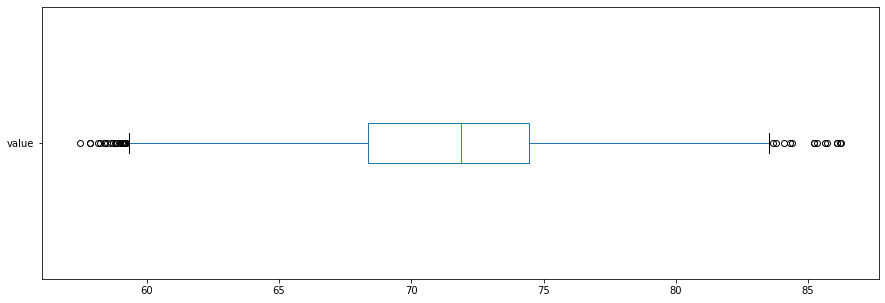

In [24]:
#Outliers
data['value'].plot.box(vert=False, figsize=(15,5))

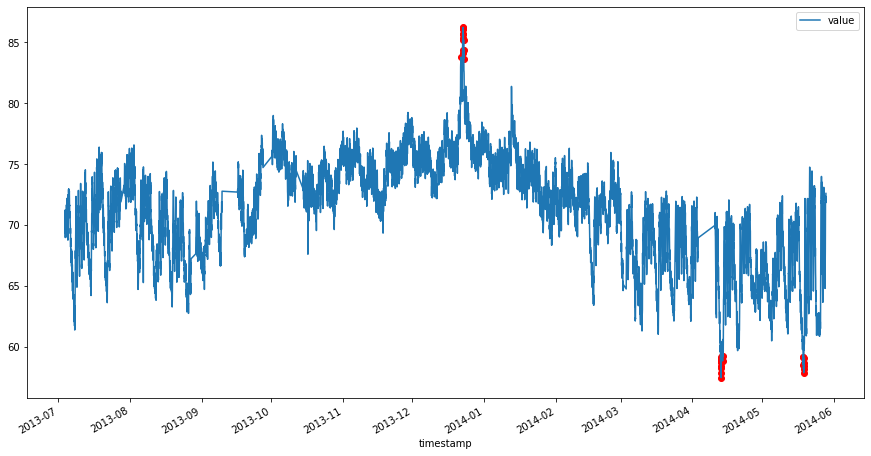

In [58]:
#find outliers
def detect_IQR(df,feature):
    q1 = df[feature].quantile(q=0.25)
    q3 = df[feature].quantile(q=0.75)
    IQR = q3-q1
    low= q1 - 1.5*IQR
    up = q3 + 1.5*IQR
    
    return low,up
low, up = detect_IQR(data,"value")

IQR_result=pd.DataFrame()
IQR_result['timestamp']=data['timestamp']
IQR_result['value'] = data['value']

#Inliers are labeled 1, while outliers are labeled -1.
IQR_result.loc[(IQR_result["value"]<low) | (IQR_result["value"]>up),"outlier"] = -1
IQR_result.loc[(IQR_result["value"]>=low) & (IQR_result["value"]<=up),"outlier"] = 1
i = IQR_result[IQR_result['outlier']==-1]
IQR_result.plot(x='timestamp', y='value', figsize=(15,8))

plt.scatter(x=i.timestamp, y=i.value, color='r')


In [151]:
from sklearn.preprocessing import LabelEncoder
cont_vars = ['value', 'hour', 't']
cat_vars = [  'is_weekend', 'daylight']
#encode the categorical data
label_encoders = [LabelEncoder() for _ in cat_vars]
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
data

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,year,t,season
0,2013-07-04 00:00:00,69.880835,0.0,3,0,0,7,2013,13728960,3
1,2013-07-04 01:00:00,71.220227,1.0,3,0,0,7,2013,13728996,3
2,2013-07-04 02:00:00,70.877805,2.0,3,0,0,7,2013,13729032,3
3,2013-07-04 03:00:00,68.959400,3.0,3,0,0,7,2013,13729068,3
4,2013-07-04 04:00:00,69.283551,4.0,3,0,0,7,2013,13729104,3
...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11.0,2,0,0,5,2014,14012748,2
7263,2014-05-28 12:00:00,72.172956,12.0,2,0,1,5,2014,14012784,2
7264,2014-05-28 13:00:00,72.046565,13.0,2,0,1,5,2014,14012820,2
7265,2014-05-28 14:00:00,71.825226,14.0,2,0,1,5,2014,14012856,2


In [160]:
#normalise the continuous variables
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
data_scaled = data.copy()
data_scaled[cont_vars] = scaler.fit_transform(data[cont_vars])
data_scaled

,timestamp,value,hour,day_of_week,is_weekend,daylight,month,year,t,season
0,2013-07-04 00:00:00,-0.320586,-1.661537,3,0,0,7,2013,-1.755168,3
1,2013-07-04 01:00:00,-0.005228,-1.517172,3,0,0,7,2013,-1.754728,3
2,2013-07-04 02:00:00,-0.085851,-1.372807,3,0,0,7,2013,-1.754287,3
3,2013-07-04 03:00:00,-0.537536,-1.228442,3,0,0,7,2013,-1.753847,3
4,2013-07-04 04:00:00,-0.461215,-1.084077,3,0,0,7,2013,-1.753406,3
...,...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,0.265532,-0.073523,2,0,0,5,2014,1.716225,2
7263,2014-05-28 12:00:00,0.219090,0.070841,2,0,1,5,2014,1.716665,2
7264,2014-05-28 13:00:00,0.189332,0.215206,2,0,1,5,2014,1.717105,2
7265,2014-05-28 14:00:00,0.137218,0.359571,2,0,1,5,2014,1.717546,2


[[ 8.67788289  4.28186928]
 [-8.0018297  -5.81067696]
 [-7.44367019  6.57468707]
 [ 8.82728363 -4.13678753]
 [ 0.43931069  4.83889194]
 [-8.67184532 -0.28061243]
 [ 3.82257812 -1.52343974]
 [-1.7696288  -3.37398688]]


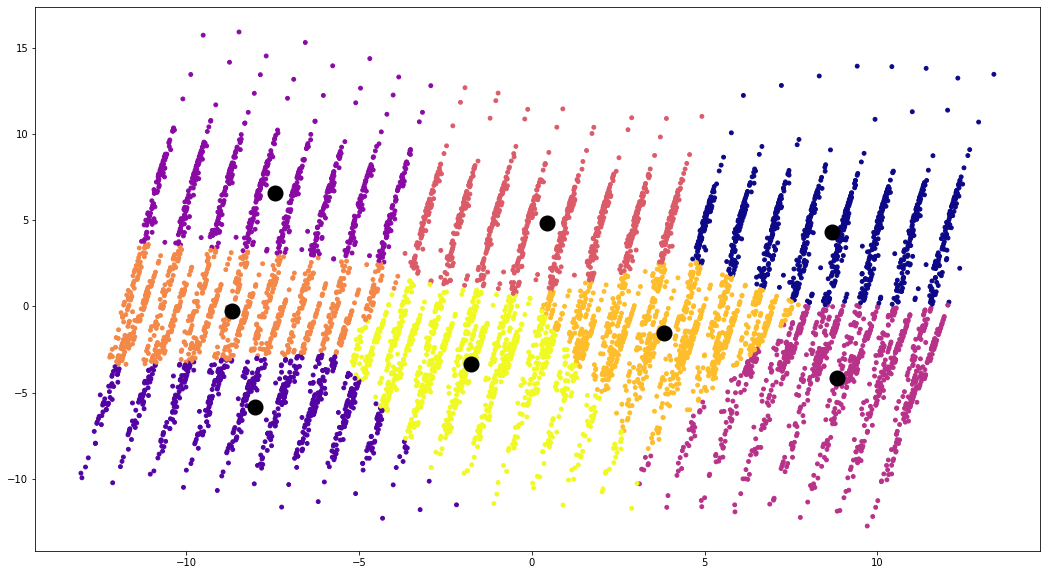

In [162]:
#Kmeans clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data_clust = data.copy().loc[:,'value':'season']
data_clust.drop('t', axis=1, inplace=True)

model = KMeans(n_clusters=8, max_iter=100)

pca = PCA(n_components=2).fit(data_clust)
pca_2d = pca.transform(data_clust)

kmeans = model.fit(pca_2d)
labl = kmeans.predict(pca_2d)

#plt.plot(pca_2d[:,0], pca_2d[:,1])
plt.figure(figsize=(18,10))
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labl, s=15, cmap='plasma')

centr = kmeans.cluster_centers_
plt.scatter(centr[:, 0], centr[:, 1], marker="o", s=169, linewidths=3, color="k")
#centr2d = pca.transform(centr)
print(centr)

<Figure size 1296x720 with 0 Axes>

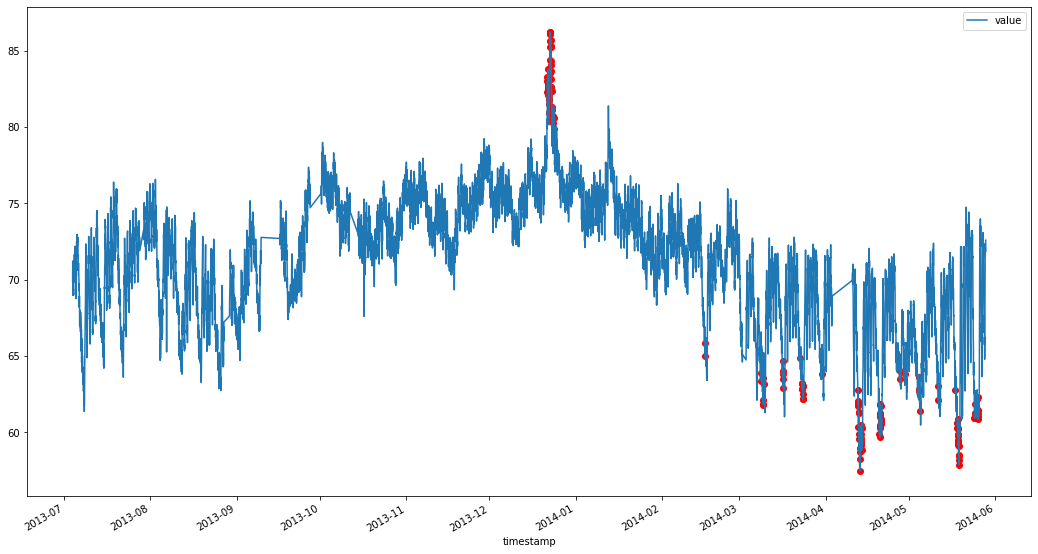

In [156]:
#outliers with kmeans clustering
clust_f = pd.DataFrame(pca_2d, columns=['feature1', 'feature2'])
clust_f['class'] = kmeans.labels_
import math

def distance(x, y):
    
    d1 = x[0] - y[0];
    d2 = x[1] - y[1];
    dist = math.sqrt(d1*d1 + d2*d2)
    return dist

def min_d(x):
    l=list()
    for i in centr:
        d = distance([clust_f.loc[x,'feature1'],clust_f.loc[x,'feature2']], i)
        l.append(d)
    m = min(l)
    return m

data_clust['distance'] = [min_d(x) for x in clust_f.index]
#data_clust['distance'] = [distance([clust_f.loc[x,'feature1'],clust_f.loc[x,'feature2']], centr[clust_f.loc[x,'class']]) for x in clust_f.index]
q = data_clust['distance'].quantile(q=0.98)
data_clust.loc[(data_clust["distance"]>q),"outlier"] = -1
data_clust.loc[(data_clust["distance"]<=q),"outlier"] = 1
data_clust['timestamp']=data['timestamp']
data_clust['value']=data['value']
c = data_clust[data_clust['outlier']==-1]

plt.figure(figsize=(18,10))
data.plot(x='timestamp', y='value', figsize=(18,10))
plt.scatter(x=c.timestamp, y=c.value, color='r')
#plt.scatter(data['timestamp'], data.value, c=colormap[get_outliers(clust_f)['class']], s=15)

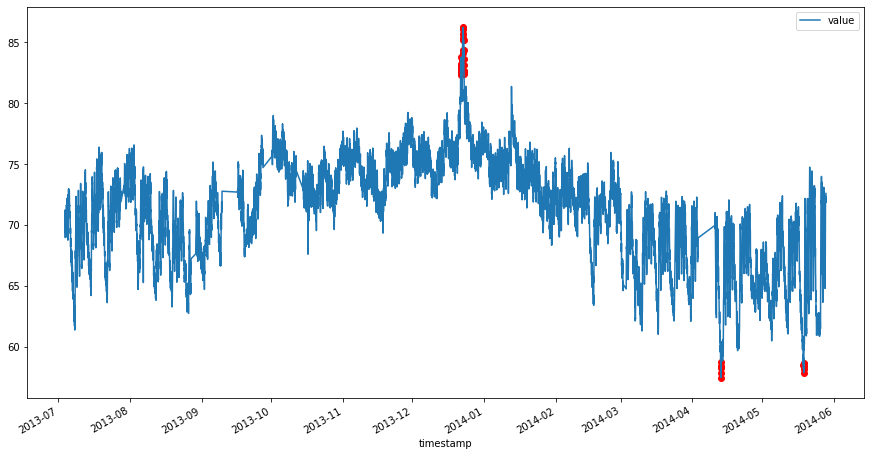

In [167]:
#isolation forest
from sklearn.ensemble import IsolationForest

iso=IsolationForest(contamination=0.005)
iso_result=iso.fit_predict(data['value'].values.reshape(-1,1))
iso_result_df=pd.DataFrame()
iso_result_df['timestamp']=data['timestamp']
iso_result_df['value'] = data['value']

#Inliers are labeled 1, while outliers are labeled -1.
iso_result_df['anomaly']  = [1 if i==-1 else 0 for i in iso_result]

iso_result_df.plot(x='timestamp', y='value', figsize=(15,8))

a=iso_result_df[iso_result_df['anomaly']==1]

plt.scatter(x=a.timestamp, y=a.value, color='r')

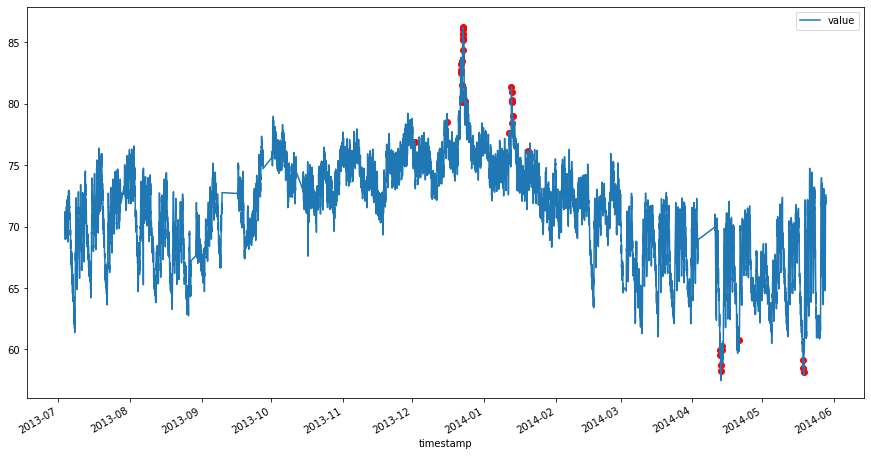

In [175]:
#Isolation Forest all features
X = data.copy().loc[:,'value':'month']
#X.drop('t', axis=1, inplace=True)
iso = iso.fit(X)

iso_all_df = X.copy()
iso_all_df['scores'] = iso.predict(X)
iso_all_df['timestamp'] = data['timestamp']
iso_all_df['anomaly'] = [0 if x>0 else 1 for x in iso_all_df['scores']]
e=iso_all_df[iso_all_df['anomaly']==1]

iso_all_df.plot(x='timestamp', y='value', figsize=(15,8))
plt.scatter(x=e.timestamp, y=e.value, color='r')